## Analysis of Taxonomy
This is a script to analyze the taxonomy files (with and without abundances)

In [25]:
#import libraries in python3 kernel
import pandas as pd
import seaborn as sns
import glob
import os
import boto
import matplotlib.pyplot as plt
import numpy as np
import skbio
from Bio import SeqIO
from Bio.SeqIO.FastaIO import SimpleFastaParser
from Bio.SeqUtils import GC
from collections import defaultdict
from collections import Counter
import statistics
%matplotlib inline

Adapt manifest and metadata files
This function outputs MERGED which is a table with the metadata attached to each ASV ids along with their respetive abundances. It takes as an input:
all_merged: output of consolidate_tables.py


In [26]:
#paths to files needed as inputs for respective functions
all_merged_path = '/Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/18S/merged_all_18s_tables.tsv'
manifestfile_path = '/Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/16S/02-PROKs/MANIFEST.tsv'
metadatafile_path = '/Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/16S/Runs_46_47_55_18years_SPOT_USC_2/METADATA_F08.tsv'
path_to_tsvs = '/Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/18S/all_trims/all_taxonomies/'
path_to_bacaro = '/Users/Diana/Documents/escuela/phd/plugin_paper/mock_code/18S/TD_metric/Bacaros_Beta/all18slvl4/all_18s_stagg_taxo.csv'
expected_file = 'expected_18s_staggered'

In [27]:
def adapt_metadata(all_merged, manifestfile, metadatafile):
    df = pd.read_csv(all_merged, sep='\t')
    tables = df[['sample_name', 'feature_id', 'feature_frequency']].copy()
    tables.rename(columns={'sample_name':'file'}, inplace=True)
    manifest = pd.read_csv(manifestfile, sep='\t')
    manifest['file'] = [s.split('SPOT_USC_2/')[1] for s in manifest['absolute-filepath']]
    manifest['file'] = [s.split('.R')[0] for s in manifest['file']]
    manifest = manifest.drop(columns = ['absolute-filepath', 'direction'])
    manifest.drop_duplicates()
    merged = pd.merge(tables,manifest, on='file')
    merged = merged.drop(columns = ['file'])
    merged = merged.drop_duplicates()
    print('Set up manifest ...')
    metadata = pd.read_csv(metadatafile, sep='\t')
    merged = pd.merge(merged,metadata, on='sample-id')
    print('Set up metadata ...')
    merged.to_csv('filtering_asvs.tsv', sep = '\t')
    print('Saved filtering_asvs.tsv')
    return merged

In [28]:
merged = adapt_metadata(all_merged_path, manifestfile_path, metadatafile_path)

Set up manifest ...
Set up metadata ...
Saved filtering_asvs.tsv


In [29]:
def get_abundances(path, composition, runnumber):
    files = glob.glob('{0}*.tsv'.format(path))
    taxos = []
#    if not os.path.exists(path+composition):
#        os.mkdir(path+composition)
    for filename in files:
        tax = pd.read_csv(filename, sep='\t')
        tax['table_id'] = str(filename.split('/')[-1])
        tax["table_id"] = tax["table_id"].str.replace(".tsv", "")
        tax['Forward_trim'], tax['Reverse_trim'] = tax['table_id'].str.split('R', 1).str
        tax['Forward_trim'] = tax['Forward_trim'].map(lambda x: x.lstrip('F'))
        taxos.append(tax)
    print('Appended all taxonomies to taxos')
    taxos = pd.concat(taxos)
    taxos = taxos.rename(columns={"Feature ID": "feature_id"}, errors="raise")
    new = taxos.merge(merged, how='left', on='feature_id')
    return new

In [30]:
new = get_abundances(path_to_tsvs, 'Staggered', '46')

/var/folders/kv/yq6jygk116l27q2bwnk25k0w0000gn/T/ipykernel_91446/1898366886.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  tax["table_id"] = tax["table_id"].str.replace(".tsv", "")
/var/folders/kv/yq6jygk116l27q2bwnk25k0w0000gn/T/ipykernel_91446/1898366886.py:10: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  tax['Forward_trim'], tax['Reverse_trim'] = tax['table_id'].str.split('R', 1).str


Appended all taxonomies to taxos


In [31]:
def load_df(path, composition, runnumber, foldername):
    files = glob.glob('{0}*.tsv'.format(path))
    for filename in files:
        tax = pd.read_csv(filename, sep='\t')
        tax = tax.rename(columns={"Feature ID": "feature_id"}, errors="raise")
        new = tax.merge(merged, how='left', on='feature_id')
        new = new.drop(['Confidence', 'sample-id'], axis=1)
        new = new.drop_duplicates()
        new = new[new["community"] == '18S']
        new = new[new["composition"] == composition]
        new['run-number']= new['run-number'].astype(str)
        new = new[new["run-number"] == runnumber]
        new.to_csv(filename.split(foldername)[0]+foldername+'/'+composition+'/'+runnumber+filename.split(foldername+'/')[1], sep = '\t')
        return files

Once all taxonomies are in the same folder, run Bacaro's delta T measure over desired taxonomic level (1 to 7)

In [32]:
def hm(path, truthfilename):
    bacaros_dm = pd.read_csv(path)
    bacaros_dm = bacaros_dm.set_index('Unnamed: 0')
    bacaros_dm = 1  - bacaros_dm
    #bacaros_dm is a distance matrix of table X table
    my_pcoa = skbio.stats.ordination.pcoa(bacaros_dm.values)
    plt.scatter(my_pcoa.samples['PC1'],  my_pcoa.samples['PC2'])
    against_exp = bacaros_dm[[truthfilename]].copy()
    against_exp = against_exp.reset_index().rename(columns={against_exp.index.name:'sample_name'})
    against_exp.drop(against_exp.index[against_exp['sample_name'] == truthfilename], inplace=True)
    against_exp['Forward_trim'] = [s.split('R')[0] for s in against_exp['sample_name']]
    against_exp['Forward_trim'] = [s.split('46F')[1] for s in against_exp['Forward_trim']]
    against_exp['Reverse_trim'] = [s.split('R')[1] for s in against_exp['sample_name']]
    against_exp["Forward_trim"] = pd.to_numeric(against_exp["Forward_trim"])
    against_exp["Reverse_trim"] = pd.to_numeric(against_exp["Reverse_trim"])
    tohm = against_exp.pivot("Forward_trim", "Reverse_trim", "expected_18s_staggered")
    ax = sns.heatmap(tohm)
    ax.invert_yaxis()
    return (tohm, bacaros_dm)

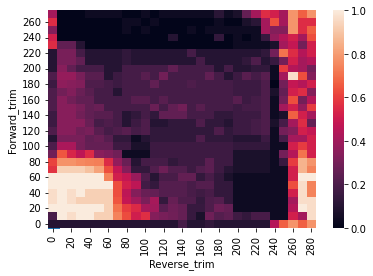

In [19]:
tohm, bacaros_dm = hm(path_to_bacaro, expected_file)